In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.express as px

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

Durante la exposición, se Durante la exposición, se debería tocar, al menos, los siguientes temas:
- Exordio (saludo, me presento, credenciales, tema y división de ideas).
- Narración en la que se incluya:
    - Breve descripción de la ciudad.
- Estudio por vecindarios (algunas ciudades, como Londres, tienen problemas en este punto).
    -  Mapa de localizaciones.
    -  Tipo de habitaciones y propiedades disponibles.
    -  Valoración sobre los superhost.
    -  Precios medios por vecindario.
    -  Seguridad por vecindario (esta información os tocará buscarla).
    -  Análisis de las reviews (limpieza, precisión, valor, comunicación, ubicación, etc).
    - Disponibilidad en el tiempo.
    - Minería de texto de las reviews.
- Peroración (recapitulación de ideas, recordatorio del tema, frase/dato impactante, agradecimientos y despedida).


In [2]:
listings = pd.read_csv("/Users/ignaciolazarovalganon/Downloads/Input/listings.csv", index_col= "id")
listings_details = pd.read_csv("/Users/ignaciolazarovalganon/Downloads/Input/listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("/Users/ignaciolazarovalganon/Downloads/Input/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("/Users/ignaciolazarovalganon/Downloads/Input/reviews_details.csv", parse_dates=['date'])

In [3]:
reviews = pd.read_csv("/Users/ignaciolazarovalganon/Downloads/Input/reviews.csv", parse_dates=['date'])

In [4]:
len(listings_details.columns)

74

In [5]:
pd.set_option('display.max_columns', None)


In [6]:
listings_details.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

In [7]:
listings_details['neighbourhood_group_cleansed']

id
2737                 NaN
3079                 NaN
103245               NaN
11834                NaN
103870               NaN
                      ..
973114587147200878   NaN
973116672976730965   NaN
973122317695245605   NaN
973124076276156534   NaN
973135638564147423   NaN
Name: neighbourhood_group_cleansed, Length: 28014, dtype: float64

In [8]:
listings_details = listings_details[['host_id','accommodates',
 'host_since', 'host_location', 
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'latitude',
       'longitude', 'property_type', 'room_type',
        'bedrooms','price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365','number_of_reviews','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','instant_bookable',
       'reviews_per_month']]

In [9]:
len(listings_details.columns)

31

In [10]:
print(listings.shape)
print(listings_details.shape)


(28014, 17)
(28014, 31)


In [11]:
# Hacemos un merge entre listing y listings_details, ya que lisitngs es un resumen para visualizaciones

listings = pd.merge(listings, listings_details, on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28014 entries, 2737 to 975133475180631768
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            28014 non-null  object 
 1   host_id_x                       28014 non-null  int64  
 2   host_name                       28014 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   28014 non-null  object 
 5   latitude_x                      28014 non-null  float64
 6   longitude_x                     28014 non-null  float64
 7   room_type_x                     28014 non-null  object 
 8   price_x                         28014 non-null  int64  
 9   minimum_nights_x                28014 non-null  int64  
 10  number_of_reviews_x             28014 non-null  int64  
 11  last_review                     24105 non-null  object 
 12  reviews_per_mont

In [12]:
listings.drop_duplicates(inplace=True)

In [13]:
listings = listings.drop(columns=['neighbourhood_group', 'latitude_y','longitude_y', 'room_type_y', 'price_y','host_name','calculated_host_listings_count',
                                   'minimum_nights_x','last_review','number_of_reviews_ltm', 'host_id_y','host_location', 'bedrooms', 'minimum_nights_y',
                                   'maximum_nights', 'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365_y', 'number_of_reviews_y', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month_y', 'license'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head(3)

name  host_id_x  \
id                                                                    
2737   Place to stay in Rome · ★4.80 · 1 bedroom · 1 ...       3047   
3079   Rental unit in Rome · ★4.53 · 1 bedroom · 1 be...       3504   
11834  Rental unit in Rome · ★4.81 · 1 bedroom · 1 be...      44552   

           neighbourhood  latitude_x  longitude_x      room_type_x  price_x  \
id                                                                            
2737   VIII Appia Antica   41.871360    12.482150     Private room       75   
3079    I Centro Storico   41.895000    12.491170  Entire home/apt       90   
11834   I Centro Storico   41.895447    12.491181  Entire home/apt      105   

       number_of_reviews_x  reviews_per_month_x  availability_365_x  \
id                                                                    
2737                     7                 0.07                 358   
3079                    21                 0.14                 130   
11834                  203                 1.35                 310   

       accommodates  host_since  host_response_time  host_response_rate  \
id                                                                        
2737              1  2008-09-18  within a few hours                98.0   
3079              4  2008-10-08        within a day               100.0   
11834             2  2009-10-09  within a few hours               100.0   

      host_acceptance_rate host_is_superhost       property_type  \
id                                                                 
2737                    3%                 f        Private room   
3079                   10%                 t  Entire rental unit   
11834                 100%                 t  Entire rental unit   

       review_scores_rating instant_bookable  
id                                            
2737                   4.80                f  
3079                   4.53                f  
11834                  4.81                f

In [14]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28011 entries, 2737 to 975133475180631768
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  28011 non-null  object 
 1   host_id_x             28011 non-null  int64  
 2   neighbourhood         28011 non-null  object 
 3   latitude_x            28011 non-null  float64
 4   longitude_x           28011 non-null  float64
 5   room_type_x           28011 non-null  object 
 6   price_x               28011 non-null  int64  
 7   number_of_reviews_x   28011 non-null  int64  
 8   reviews_per_month_x   24105 non-null  float64
 9   availability_365_x    28011 non-null  int64  
 10  accommodates          28011 non-null  int64  
 11  host_since            28011 non-null  object 
 12  host_response_time    24376 non-null  object 
 13  host_response_rate    24376 non-null  float64
 14  host_acceptance_rate  25517 non-null  object 
 15  hos

In [15]:
nulls = listings.isna().sum()
nulls_percentatge = (nulls/len(listings)*100).sort_values(ascending=False)
nulls_percentatge[nulls_percentatge>0]

review_scores_rating    13.944522
reviews_per_month_x     13.944522
host_response_rate      12.977045
host_response_time      12.977045
host_acceptance_rate     8.903645
host_is_superhost        3.184463
dtype: float64

<AxesSubplot: ylabel='id'>

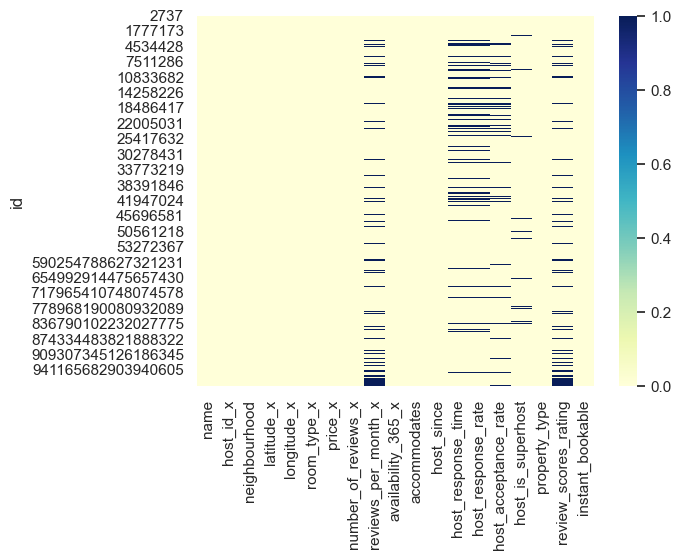

In [16]:
sns.heatmap(data = listings.isna(),cmap="YlGnBu", )

In [17]:
# Utilizamos el KNN Imputer para tratar los missing values vistos anteriormente, primero arreglaremos los valores de las columnas y daremos valores númericos a las categóricas 

listings[['review_scores_rating','reviews_per_month_x','host_response_rate','host_response_time','host_acceptance_rate','host_is_superhost']].head(3)


review_scores_rating  reviews_per_month_x  host_response_rate  \
id                                                                     
2737                   4.80                 0.07                98.0   
3079                   4.53                 0.14               100.0   
11834                  4.81                 1.35               100.0   

       host_response_time host_acceptance_rate host_is_superhost  
id                                                                
2737   within a few hours                   3%                 f  
3079         within a day                  10%                 t  
11834  within a few hours                 100%                 t

In [18]:
listings['host_response_time'].unique()

array(['within a few hours', 'within a day', 'within an hour', nan,
       'a few days or more'], dtype=object)

In [19]:
listings['host_response_time'] = listings['host_response_time'].replace({'within an hour': 0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3})

In [20]:
listings['host_response_time'].unique()

array([ 1.,  2.,  0., nan,  3.])

In [21]:
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.split('%').str.get(0)

In [22]:
listings['host_is_superhost'] = listings['host_is_superhost'].replace({'f': 0, 't': 1})

In [23]:
listings['host_is_superhost'].unique()

array([ 0.,  1., nan])

In [24]:
listings['property_type'].value_counts().sort_values(ascending=False).head(15)

Entire rental unit                    12647
Entire condo                           4519
Private room in rental unit            3189
Private room in bed and breakfast      1813
Private room in condo                  1067
Entire home                             758
Entire loft                             540
Entire vacation home                    514
Room in boutique hotel                  418
Room in bed and breakfast               312
Private room in serviced apartment      301
Private room in home                    285
Entire serviced apartment               251
Room in hotel                           211
Entire villa                            133
Name: property_type, dtype: int64

In [25]:
# Eliminamos la columna property_type ya que room_type_x ya nos da la información que queremos
listings.drop(['property_type'], axis=1, inplace=True)

In [26]:
listings['room_type_x'].unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

In [27]:
listings['room_type_x'] = listings['room_type_x'].replace({'Private room': 0, 'Shared room': 1, 'Hotel room': 2, 'Entire home/apt': 3})

In [28]:
listings['neighbourhood'].value_counts().sort_values()

VI Roma delle Torri             243
IX Eur                          359
III Monte Sacro                 468
XV Cassia/Flaminia              480
XI Arvalia/Portuense            505
IV Tiburtina                    519
XIV Monte Mario                 584
VIII Appia Antica               796
X Ostia/Acilia                  801
V Prenestino/Centocelle        1144
XII Monte Verde                1419
XIII Aurelia                   1697
II Parioli/Nomentano           1962
VII San Giovanni/Cinecittà     2079
I Centro Storico              14955
Name: neighbourhood, dtype: int64

In [29]:
listings['neighbourhood'] = listings['neighbourhood'].replace({'I Centro Storico': 0,
    'II Parioli/Nomentano': 1, 
    'III Monte Sacro': 2, 
    'IV Tiburtina': 3,
    'V Prenestino/Centocelle': 4, 
    'VI Roma delle Torri': 5, 
    'VII San Giovanni/Cinecittà': 6,
    'VIII Appia Antica': 7, 
    'IX Eur': 8, 
    'X Ostia/Acilia': 9,
    'XI Arvalia/Portuense': 10,
    'XII Monte Verde': 11, 
    'XIII Aurelia': 12, 
    'XIV Monte Mario': 13,
    'XV Cassia/Flaminia': 14
})

In [30]:
listings['instant_bookable'] = listings['instant_bookable'].replace({'f': 0, 't': 1})

In [31]:
listings.drop('name', axis=1, inplace=True)

In [32]:
listings['host_since'] = pd.to_datetime(listings['host_since'], format='%Y/%m/%d')


In [33]:
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].astype(float)

In [34]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28011 entries, 2737 to 975133475180631768
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   host_id_x             28011 non-null  int64         
 1   neighbourhood         28011 non-null  int64         
 2   latitude_x            28011 non-null  float64       
 3   longitude_x           28011 non-null  float64       
 4   room_type_x           28011 non-null  int64         
 5   price_x               28011 non-null  int64         
 6   number_of_reviews_x   28011 non-null  int64         
 7   reviews_per_month_x   24105 non-null  float64       
 8   availability_365_x    28011 non-null  int64         
 9   accommodates          28011 non-null  int64         
 10  host_since            28011 non-null  datetime64[ns]
 11  host_response_time    24376 non-null  float64       
 12  host_response_rate    24376 non-null  float64       
 13  

In [35]:
listings.head(3)

host_id_x  neighbourhood  latitude_x  longitude_x  room_type_x  \
id                                                                      
2737        3047              7   41.871360    12.482150            0   
3079        3504              0   41.895000    12.491170            3   
11834      44552              0   41.895447    12.491181            3   

       price_x  number_of_reviews_x  reviews_per_month_x  availability_365_x  \
id                                                                             
2737        75                    7                 0.07                 358   
3079        90                   21                 0.14                 130   
11834      105                  203                 1.35                 310   

       accommodates host_since  host_response_time  host_response_rate  \
id                                                                       
2737              1 2008-09-18                 1.0                98.0   
3079              4 2008-10-08                 2.0               100.0   
11834             2 2009-10-09                 1.0               100.0   

       host_acceptance_rate  host_is_superhost  review_scores_rating  \
id                                                                     
2737                    3.0                0.0                  4.80   
3079                   10.0                1.0                  4.53   
11834                 100.0                1.0                  4.81   

       instant_bookable  
id                       
2737                  0  
3079                  0  
11834                 0

In [36]:
listings.shape

(28011, 17)

In [37]:
# Utilizamos el KNN Imputer para tratar los missing values vistos anteriormente

from sklearn.impute import KNNImputer

X = listings.drop('host_since', axis=1)
impute_knn = KNNImputer(n_neighbors=5)
listings_knn = pd.DataFrame(impute_knn.fit_transform(X), columns=X.columns)


In [38]:
listings_knn['host_is_superhost'].value_counts()

0.0    18852
1.0     8552
0.2      213
0.4      166
0.6      150
0.8       78
Name: host_is_superhost, dtype: int64

In [39]:
listings_knn['host_is_superhost'] = listings_knn['host_is_superhost'].replace({0.2: 0, 0.4: 0, 0.6:1, 0.8:1})

In [40]:
listings_knn['host_is_superhost'].value_counts()

0.0    19231
1.0     8780
Name: host_is_superhost, dtype: int64

In [41]:
listings_knn.head()

host_id_x  neighbourhood  latitude_x  longitude_x  room_type_x  price_x  \
0     3047.0            7.0   41.871360    12.482150          0.0     75.0   
1     3504.0            0.0   41.895000    12.491170          3.0     90.0   
2    44552.0            0.0   41.895447    12.491181          3.0    105.0   
3   538724.0            0.0   41.887880    12.469750          3.0    110.0   
4    11756.0            1.0   41.925820    12.469280          3.0    121.0   

   number_of_reviews_x  reviews_per_month_x  availability_365_x  accommodates  \
0                  7.0                 0.07               358.0           1.0   
1                 21.0                 0.14               130.0           4.0   
2                203.0                 1.35               310.0           2.0   
3                389.0                 2.60               266.0           6.0   
4                 59.0                 0.38               303.0           6.0   

   host_response_time  host_response_rate  host_acceptance_rate  \
0                 1.0                98.0                   3.0   
1                 2.0               100.0                  10.0   
2                 1.0               100.0                 100.0   
3                 0.0               100.0                 100.0   
4                 1.0               100.0                  82.0   

   host_is_superhost  review_scores_rating  instant_bookable  
0                0.0                  4.80               0.0  
1                1.0                  4.53               0.0  
2                1.0                  4.81               0.0  
3                1.0                  4.87               1.0  
4                1.0                  4.91               0.0

In [42]:
listings_knn.isna().sum()

host_id_x               0
neighbourhood           0
latitude_x              0
longitude_x             0
room_type_x             0
price_x                 0
number_of_reviews_x     0
reviews_per_month_x     0
availability_365_x      0
accommodates            0
host_response_time      0
host_response_rate      0
host_acceptance_rate    0
host_is_superhost       0
review_scores_rating    0
instant_bookable        0
dtype: int64

In [43]:
listings_knn['neighbourhood'] = listings_knn['neighbourhood'].replace({0 : 'I Centro Storico',
    1 : 'II Parioli/Nomentano', 
    2: 'III Monte Sacro', 
    3:'IV Tiburtina' ,
    4: 'V Prenestino/Centocelle', 
    5:'VI Roma delle Torri' , 
    6: 'VII San Giovanni/Cinecittà',
    7: 'VIII Appia Antica', 
    8: 'IX Eur', 
    9: 'X Ostia/Acilia',
    10: 'XI Arvalia/Portuense',
    11: 'XII Monte Verde', 
    12: 'XIII Aurelia', 
    13: 'XIV Monte Mario',
    14: 'XV Cassia/Flaminia'
})

In [44]:
listings_knn['host_response_time'] = listings_knn['host_response_time'].replace({0: 'within an hour', 1: 'within a few hours', 2: 'within a day', 3: 'a few days or more'})

listings_knn['room_type_x'] = listings_knn['room_type_x'].replace({0: 'Private room', 1: 'Shared room', 2: 'Hotel room', 3: 'Entire home/apt'})

In [45]:
listings_knn.head(3)

host_id_x      neighbourhood  latitude_x  longitude_x      room_type_x  \
0     3047.0  VIII Appia Antica   41.871360    12.482150     Private room   
1     3504.0   I Centro Storico   41.895000    12.491170  Entire home/apt   
2    44552.0   I Centro Storico   41.895447    12.491181  Entire home/apt   

   price_x  number_of_reviews_x  reviews_per_month_x  availability_365_x  \
0     75.0                  7.0                 0.07               358.0   
1     90.0                 21.0                 0.14               130.0   
2    105.0                203.0                 1.35               310.0   

   accommodates  host_response_time  host_response_rate  host_acceptance_rate  \
0           1.0  within a few hours                98.0                   3.0   
1           4.0        within a day               100.0                  10.0   
2           2.0  within a few hours               100.0                 100.0   

   host_is_superhost  review_scores_rating  instant_bookable  
0                0.0                  4.80               0.0  
1                1.0                  4.53               0.0  
2                1.0                  4.81               0.0

## Ánalisis exploratorio


In [46]:
title = "Number of listings by neighbourhood"
figura = listings_knn['neighbourhood'].value_counts().sort_values(ascending=True)
px.bar(figura,title=title,  template='plotly_white',orientation='h')



In [76]:
# Hacemos un mapa con todos los alojamientos de Roma, cada color indica el tipo de alojamiento y el tamaño depende de su precio
review = listings_knn
px.scatter_mapbox(review, lat='latitude_x', lon='longitude_x', size='price_x', zoom=10, mapbox_style='carto-positron', title='AirBnb Apartment Distribution in Roma', template= "plotly_dark", size_max=20, color='room_type_x')

In [48]:
# Agrupamos los alojamientos escogiendo solo los de 2 personas, que son los más comunes.

feq2 = listings_knn[listings_knn['accommodates']==2]

feq2 = feq2.groupby('neighbourhood')['price_x'].mean().sort_values(ascending=True)

In [49]:
feq2 = pd.DataFrame(feq2)
feq2

price_x
neighbourhood                         
VI Roma delle Torri          72.890000
XI Arvalia/Portuense         79.171271
VIII Appia Antica            93.507407
XIV Monte Mario              94.372222
III Monte Sacro              94.886076
XII Monte Verde              95.177874
V Prenestino/Centocelle      96.705776
VII San Giovanni/Cinecittà  100.228412
X Ostia/Acilia              102.155000
XV Cassia/Flaminia          105.247126
IX Eur                      108.752381
IV Tiburtina                113.257143
XIII Aurelia                119.299048
II Parioli/Nomentano        180.191520
I Centro Storico            188.610032

In [50]:
adam = gpd.read_file("/Users/ignaciolazarovalganon/Downloads/Input/neighbourhoods.geojson")
# Asegurarse de que 'feq' es un DataFrame de pandas correcto antes de transponerlo
# Si 'feq' es un DataFrame, no necesitamos encapsularlo en una lista y convertirlo a DataFrame otra vez

# Mezclamos
adam = pd.merge(adam, feq2, on='neighbourhood', how='left')


In [51]:
# Renombramos la columna
adam.rename(columns={'price_x': 'average_price'}, inplace=True)
adam

neighbourhood  neighbourhood_group  \
0             I Centro Storico                  NaN   
1              III Monte Sacro                  NaN   
2                 IV Tiburtina                  NaN   
3          VI Roma delle Torri                  NaN   
4   VII San Giovanni/Cinecittà                  NaN   
5            VIII Appia Antica                  NaN   
6                       IX Eur                  NaN   
7               X Ostia/Acilia                  NaN   
8         XI Arvalia/Portuense                  NaN   
9              XII Monte Verde                  NaN   
10                XIII Aurelia                  NaN   
11             XIV Monte Mario                  NaN   
12          XV Cassia/Flaminia                  NaN   
13     V Prenestino/Centocelle                  NaN   
14        II Parioli/Nomentano                  NaN   

                                             geometry  average_price  
0   MULTIPOLYGON (((12.44396 41.93390, 12.44472 41...     188.610032  
1   MULTIPOLYGON (((12.56321 42.07464, 12.56269 42...      94.886076  
2   MULTIPOLYGON (((12.63542 41.95729, 12.63696 41...     113.257143  
3   MULTIPOLYGON (((12.70671 41.93375, 12.70691 41...      72.890000  
4   MULTIPOLYGON (((12.51668 41.89194, 12.52266 41...     100.228412  
5   MULTIPOLYGON (((12.48108 41.87642, 12.48137 41...      93.507407  
6   MULTIPOLYGON (((12.47554 41.84734, 12.47616 41...     108.752381  
7   MULTIPOLYGON (((12.35255 41.80295, 12.35351 41...     102.155000  
8   MULTIPOLYGON (((12.28997 41.82954, 12.28645 41...      79.171271  
9   MULTIPOLYGON (((12.25065 41.87581, 12.24905 41...      95.177874  
10  MULTIPOLYGON (((12.30750 41.96183, 12.30996 41...     119.299048  
11  MULTIPOLYGON (((12.29248 42.03120, 12.29396 42...      94.372222  
12  MULTIPOLYGON (((12.34895 42.10263, 12.35080 42...     105.247126  
13  MULTIPOLYGON (((12.61538 41.89946, 12.61529 41...      96.705776  
14  MULTIPOLYGON (((12.50098 41.94215, 12.50117 41...     180.191520

In [52]:
import branca.colormap as cm

In [53]:
# Redondeamos el precio
adam['average_price'] = adam['average_price'].round(decimals=2)

# Conseguimos colores para nuestras casas 
map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = cm.linear.YlOrRd_07.scale(vmin = min(map_dict.values()), vmax = max(map_dict.values()))
def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    if value is not None:
        return color_scale(value)
    else:
        return 'grey'  # Un color predeterminado si el barrio no está en el diccionario

In [54]:

# Hacemos el mapa
map3 = folium.Map(location=[41.902652, 12.484885], zoom_start=11)
folium.GeoJson(data=adam,
               name='Roma',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=True),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.55
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.9}).add_to(map3)
map3

In [55]:
# Al ser el centro Storico el barrio que con más diferencia tiene alojamientos vamos a estudiarlo detenidamente

centro_listings = listings_knn[listings_knn['neighbourhood']=='I Centro Storico']
centro_listings.head()

host_id_x     neighbourhood  latitude_x  longitude_x      room_type_x  \
1     3504.0  I Centro Storico   41.895000    12.491170  Entire home/apt   
2    44552.0  I Centro Storico   41.895447    12.491181  Entire home/apt   
3   538724.0  I Centro Storico   41.887880    12.469750  Entire home/apt   
5   535822.0  I Centro Storico   41.897110    12.504230  Entire home/apt   
6    75450.0  I Centro Storico   41.907300    12.453490  Entire home/apt   

   price_x  number_of_reviews_x  reviews_per_month_x  availability_365_x  \
1     90.0                 21.0                 0.14               130.0   
2    105.0                203.0                 1.35               310.0   
3    110.0                389.0                 2.60               266.0   
5     94.0                289.0                 1.94               307.0   
6    165.0                127.0                 0.89                66.0   

   accommodates  host_response_time  host_response_rate  host_acceptance_rate  \
1           4.0        within a day               100.0                  10.0   
2           2.0  within a few hours               100.0                 100.0   
3           6.0      within an hour               100.0                 100.0   
5           3.0      within an hour               100.0                 100.0   
6           6.0      within an hour               100.0                  97.0   

   host_is_superhost  review_scores_rating  instant_bookable  
1                1.0                  4.53               0.0  
2                1.0                  4.81               0.0  
3                1.0                  4.87               1.0  
5                0.0                  4.18               1.0  
6                0.0                  4.47               1.0

In [56]:
px.bar(listings_knn.groupby('neighbourhood').agg('mean')['accommodates'], title='Media de huéspedes por alojamiento  por barrio')

In [57]:
px.bar(centro_listings['accommodates'].value_counts(), title='Número de alojamientos por cada núm de huéspedes en el barrio Centro Storico')

In [58]:
feq2 = listings_knn[listings_knn['accommodates']==2]

feq2 = feq2.groupby('neighbourhood')['price_x'].mean().sort_values(ascending=True)
feq2 = pd.DataFrame(feq2)
feq2 =feq2.sort_values(by='neighbourhood', ascending=True)
feq2 = feq2.reset_index()
feq2


neighbourhood     price_x
0             I Centro Storico  188.610032
1         II Parioli/Nomentano  180.191520
2              III Monte Sacro   94.886076
3                 IV Tiburtina  113.257143
4                       IX Eur  108.752381
5      V Prenestino/Centocelle   96.705776
6          VI Roma delle Torri   72.890000
7   VII San Giovanni/Cinecittà  100.228412
8            VIII Appia Antica   93.507407
9               X Ostia/Acilia  102.155000
10        XI Arvalia/Portuense   79.171271
11             XII Monte Verde   95.177874
12                XIII Aurelia  119.299048
13             XIV Monte Mario   94.372222
14          XV Cassia/Flaminia  105.247126

In [59]:
feq3 = listings_knn[listings_knn['accommodates']==3]

feq3 = feq3.groupby('neighbourhood')['price_x'].mean().sort_values(ascending=True)
feq3 = pd.DataFrame(feq3)
feq3 =feq3.sort_values(by='neighbourhood', ascending=True)
feq3 = feq3.reset_index()
feq3


neighbourhood     price_x
0             I Centro Storico  205.997238
1         II Parioli/Nomentano  197.540426
2              III Monte Sacro  203.229508
3                 IV Tiburtina   81.484848
4                       IX Eur  233.245614
5      V Prenestino/Centocelle   76.488722
6          VI Roma delle Torri  107.241379
7   VII San Giovanni/Cinecittà  146.052045
8            VIII Appia Antica  130.000000
9               X Ostia/Acilia   87.120000
10        XI Arvalia/Portuense   98.723077
11             XII Monte Verde  115.540230
12                XIII Aurelia  155.236181
13             XIV Monte Mario  228.703704
14          XV Cassia/Flaminia   90.957447

In [60]:
feq4 = listings_knn[listings_knn['accommodates']==4]

feq4 = feq4.groupby('neighbourhood')['price_x'].mean().sort_values(ascending=True)
feq4 = pd.DataFrame(feq4)
feq4 =feq4.sort_values(by='neighbourhood', ascending=True)
feq4 = feq4.reset_index()
feq4


neighbourhood     price_x
0             I Centro Storico  245.135985
1         II Parioli/Nomentano  173.044487
2              III Monte Sacro  147.585586
3                 IV Tiburtina  221.261261
4                       IX Eur  283.937500
5      V Prenestino/Centocelle  115.401575
6          VI Roma delle Torri   92.708333
7   VII San Giovanni/Cinecittà  122.393822
8            VIII Appia Antica  127.047619
9               X Ostia/Acilia  133.597015
10        XI Arvalia/Portuense  877.124088
11             XII Monte Verde  163.027211
12                XIII Aurelia  150.937355
13             XIV Monte Mario  187.000000
14          XV Cassia/Flaminia  115.267123

In [61]:
mean_ac = pd.DataFrame(listings_knn.groupby('neighbourhood').agg('mean')['accommodates']).reset_index()
val = pd.DataFrame(centro_listings['accommodates'].value_counts()).reset_index()
val = val.rename(columns={'index': 'accommodates', 'accommodates':'count'})
figura = listings_knn['neighbourhood'].value_counts().sort_values(ascending=True)
figura =pd.DataFrame(figura).reset_index()
figura = figura .rename(columns={'index': 'neighbourhood', 'neighbourhood':'count'})  

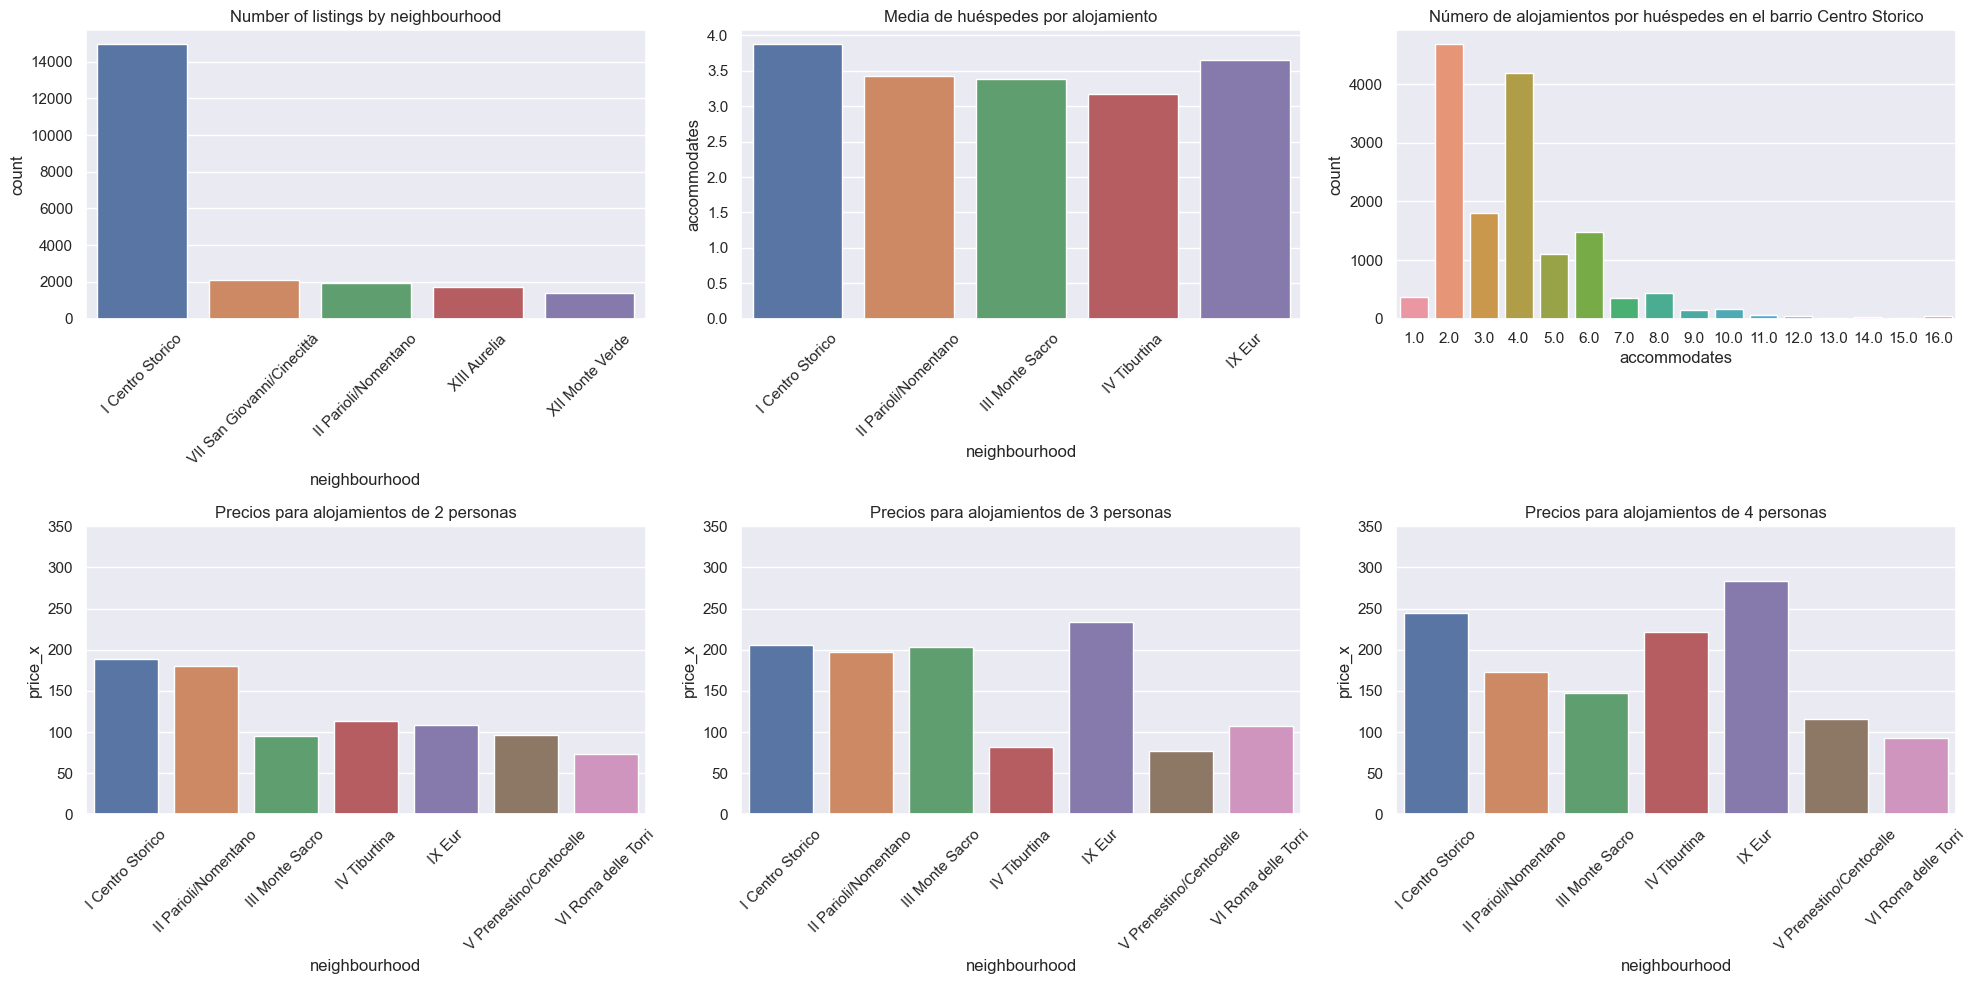

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
y_range = (0, 350)

sns.barplot(ax=axes[1,0],x=feq2['neighbourhood'].head(7), y='price_x', data=feq2)
axes[1,0].set_title('Precios para alojamientos de 2 personas')
plt.sca(axes[1,0])
plt.xticks(rotation=45)
axes[1,0].set_ylim(y_range)


sns.barplot(ax=axes[1,1],x=feq3['neighbourhood'].head(7), y='price_x', data=feq3)
axes[1,1].set_title('Precios para alojamientos de 3 personas')
plt.sca(axes[1,1])
plt.xticks(rotation=45)
axes[1,1].set_ylim(y_range)

sns.barplot(ax=axes[1,2],x=feq3['neighbourhood'].head(7), y='price_x', data=feq4)
axes[1,2].set_title('Precios para alojamientos de 4 personas')
plt.sca(axes[1,2])
plt.xticks(rotation=45)
axes[1,2].set_ylim(y_range)



sns.barplot( data=mean_ac.head(), ax=axes[0,1], x='neighbourhood', y= 'accommodates')
axes[0,1].set_title('Media de huéspedes por alojamiento')
plt.sca(axes[0,1])
plt.xticks(rotation=45)

sns.barplot(data= val, ax=axes[0,2], x= 'accommodates', y='count')
axes[0,2].set_title('Número de alojamientos por huéspedes en el barrio Centro Storico')



sns.barplot(data=figura.sort_values(by= 'count',ascending=False).head(), x= 'neighbourhood', y='count', ax=axes[0,0])
axes[0,0].set_title("Number of listings by neighbourhood")
plt.sca(axes[0,0])
plt.xticks(rotation=45)

plt.tight_layout();

In [63]:
# Después de analizar los datos por barrio hemos visto como el Centro Storico es con mucha diferencia el barrio donde más alojamientos hay,
# estos alojamientos suelen ser de entre 2-4 personas, teniendo una media mayor que el resto de los barrios.
# Si noc centramos en el precio y diferenciamos los alojamientos según el nombre de huéspedes para el que se presenta, tanto para 2, 3 y 4 personas
# tiene de media un precio de los más altos.

## Superhost

#### Requisitos

     Para conseguir el distintivo, debes ser el propietario del anuncio y tener una cuenta en regla que cumpla los siguientes requisitos:

 - Haber completado como mínimo 10 estancias o 3 reservas que sumen al menos 100 noches en total.
 - Haber mantenido un índice de respuesta del 90 % o un porcentaje superior.
 - Haber mantenido un índice de cancelación de menos del 1 %, salvo en el caso de las cancelaciones que contempla nuestra Política de Causas de Fuerza Mayor.
 - Haber mantenido una valoración general de 4,8. Recuerda que la valoración se tiene en cuenta cuando tanto el huésped como el anfitrión han publicado una evaluación o ha terminado el plazo de 14    - días   para hacerlo, lo que ocurra primero.

In [64]:
listings_knn.head()

host_id_x         neighbourhood  latitude_x  longitude_x      room_type_x  \
0     3047.0     VIII Appia Antica   41.871360    12.482150     Private room   
1     3504.0      I Centro Storico   41.895000    12.491170  Entire home/apt   
2    44552.0      I Centro Storico   41.895447    12.491181  Entire home/apt   
3   538724.0      I Centro Storico   41.887880    12.469750  Entire home/apt   
4    11756.0  II Parioli/Nomentano   41.925820    12.469280  Entire home/apt   

   price_x  number_of_reviews_x  reviews_per_month_x  availability_365_x  \
0     75.0                  7.0                 0.07               358.0   
1     90.0                 21.0                 0.14               130.0   
2    105.0                203.0                 1.35               310.0   
3    110.0                389.0                 2.60               266.0   
4    121.0                 59.0                 0.38               303.0   

   accommodates  host_response_time  host_response_rate  host_acceptance_rate  \
0           1.0  within a few hours                98.0                   3.0   
1           4.0        within a day               100.0                  10.0   
2           2.0  within a few hours               100.0                 100.0   
3           6.0      within an hour               100.0                 100.0   
4           6.0  within a few hours               100.0                  82.0   

   host_is_superhost  review_scores_rating  instant_bookable  
0                0.0                  4.80               0.0  
1                1.0                  4.53               0.0  
2                1.0                  4.81               0.0  
3                1.0                  4.87               1.0  
4                1.0                  4.91               0.0

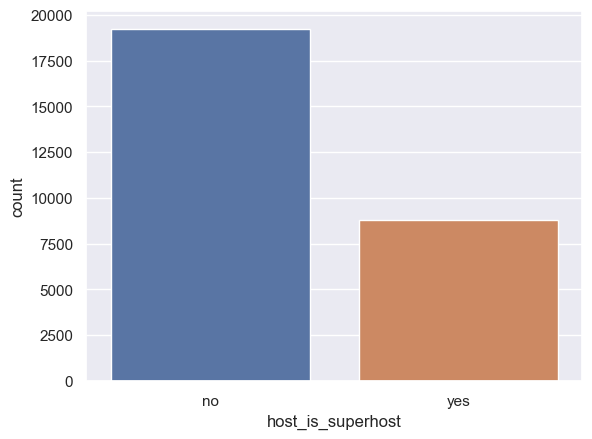

In [65]:
g = sns.countplot(x='host_is_superhost', data=listings_knn)
g.set_xticklabels(['no', 'yes']);

In [66]:
private = listings_knn[listings_knn['room_type_x'] == "Private room"]
host_private = private.groupby(['host_id_x']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

host_id_x  private_rooms
2588  270954123.0             39
2439  230950667.0             28
495     8973851.0             22
952    24459917.0             21
318     4453257.0             18

In [67]:
private = listings_knn[listings_knn['room_type_x'] == 'Entire home/apt']
host_private = private.groupby(['host_id_x']).size().reset_index(name='entire_home').sort_values(by=['entire_home'], ascending=False)
host_private.head()

host_id_x  entire_home
3094  23532561.0          254
6006  96122546.0          160
5242  63191555.0           67
249    1107433.0           61
556    2405376.0           61

In [68]:
df_superhost = listings_knn[listings_knn['host_is_superhost']==1]
df_superhost.head()

host_id_x         neighbourhood  latitude_x  longitude_x      room_type_x  \
1      3504.0      I Centro Storico   41.895000    12.491170  Entire home/apt   
2     44552.0      I Centro Storico   41.895447    12.491181  Entire home/apt   
3    538724.0      I Centro Storico   41.887880    12.469750  Entire home/apt   
4     11756.0  II Parioli/Nomentano   41.925820    12.469280  Entire home/apt   
12    77932.0          XIII Aurelia   41.896890    12.456950  Entire home/apt   

    price_x  number_of_reviews_x  reviews_per_month_x  availability_365_x  \
1      90.0                 21.0                 0.14               130.0   
2     105.0                203.0                 1.35               310.0   
3     110.0                389.0                 2.60               266.0   
4     121.0                 59.0                 0.38               303.0   
12   2000.0                135.0                 0.85                 7.0   

    accommodates  host_response_time  host_response_rate  \
1            4.0        within a day               100.0   
2            2.0  within a few hours               100.0   
3            6.0      within an hour               100.0   
4            6.0  within a few hours               100.0   
12           7.0      within an hour               100.0   

    host_acceptance_rate  host_is_superhost  review_scores_rating  \
1                   10.0                1.0                  4.53   
2                  100.0                1.0                  4.81   
3                  100.0                1.0                  4.87   
4                   82.0                1.0                  4.91   
12                 100.0                1.0                  4.77   

    instant_bookable  
1                0.0  
2                0.0  
3                1.0  
4                0.0  
12               1.0

In [74]:
# Hacemos un mapa con todos los alojamientos de Roma, cada color indica el tipo de alojamiento y el tamaño depende de su precio
review = df_superhost

fig = px.scatter_mapbox(review, lat='latitude_x', lon='longitude_x', size='price_x', zoom=10, mapbox_style='carto-positron',
                   title='AirBnb Superhost Apartment Distribution in Roma', template= "plotly_dark", size_max=20, 
                   color='review_scores_rating',range_color=[4.7, 5])

fig

In [72]:
df_superhost.head(3)

host_id_x     neighbourhood  latitude_x  longitude_x      room_type_x  \
1     3504.0  I Centro Storico   41.895000    12.491170  Entire home/apt   
2    44552.0  I Centro Storico   41.895447    12.491181  Entire home/apt   
3   538724.0  I Centro Storico   41.887880    12.469750  Entire home/apt   

   price_x  number_of_reviews_x  reviews_per_month_x  availability_365_x  \
1     90.0                 21.0                 0.14               130.0   
2    105.0                203.0                 1.35               310.0   
3    110.0                389.0                 2.60               266.0   

   accommodates  host_response_time  host_response_rate  host_acceptance_rate  \
1           4.0        within a day               100.0                  10.0   
2           2.0  within a few hours               100.0                 100.0   
3           6.0      within an hour               100.0                 100.0   

   host_is_superhost  review_scores_rating  instant_bookable  
1                1.0                  4.53               0.0  
2                1.0                  4.81               0.0  
3                1.0                  4.87               1.0

In [73]:
listings_knn.groupby('host_is_superhost').agg('mean')[['review_scores_rating','price_x','reviews_per_month_x','accommodates', 'host_response_rate', 'host_acceptance_rate']]

review_scores_rating     price_x  reviews_per_month_x  \
host_is_superhost                                                          
0.0                            4.613766  214.028132             1.418017   
1.0                            4.852960  193.949089             2.309939   

                   accommodates  host_response_rate  host_acceptance_rate  
host_is_superhost                                                          
0.0                    3.648328           93.008985             85.606115  
1.0                    3.815034           99.105239             96.337540

In [84]:
df_monumento = pd.DataFrame({'Monumento':['Coliseo','Vaticano','Fontana di Trevi','Panteon', 'Foro Romano'], 'latitude':[41.8902692,41.9038162,41.9010332,41.8986108,41.8924623],
              'longitude':[12.4918651,12.4469113,12.478402,12.474298,12.4827501]
              })
df_monumento

Monumento   latitude  longitude
0           Coliseo  41.890269  12.491865
1          Vaticano  41.903816  12.446911
2  Fontana di Trevi  41.901033  12.478402
3           Panteon  41.898611  12.474298
4       Foro Romano  41.892462  12.482750

In [132]:
mapsuperhost = folium.plugins.DualMap(location=[41.900735, 12.483280], zoom_start=12)

# Datos de ubicaciones de superhost
latssuperhost = df_superhost['latitude_x'].tolist()
lonssuperhost = df_superhost['longitude_x'].tolist()
locations = list(zip(latssuperhost, lonssuperhost),)

# Agregar ubicaciones de superhost al mapa
FastMarkerCluster(data=locations).add_to(mapsuperhost.m1)


# Datos de ubicaciones de monumentos
latsmon = df_monumento['latitude'].tolist()
longmon = df_monumento['longitude'].tolist()
locsmon = list(zip(latsmon, longmon),)


nombres_monumentos = df_monumento['Monumento'].tolist()

# Agregar ubicaciones de monumentos al mapa con marcadores personalizados
for loc,nombre in zip(locsmon, nombres_monumentos):
    folium.Marker(
        location=loc,
        icon=folium.Icon(icon='info-sign'),  # Icono personalizado, ajusta según tus preferencias
        tooltip= nombre # Texto que aparecerá al pasar el ratón
    ).add_to(mapsuperhost.m2)



# Hacemos el mapa
map3 = folium.Map(location=[41.902652, 12.484885], zoom_start=11)
folium.GeoJson(data=adam,
               name='Roma',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=True),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.55
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.9}).add_to(mapsuperhost.m2)
map3



mapsuperhost

#### A/B Testing para comprobar si ser SuperHosrt cambia sustancialmente el precio

In [134]:
grupo_super = listings_knn[listings_knn['host_is_superhost']==1]['price_x']
grupo_Not_super = listings_knn[listings_knn['host_is_superhost']==0]['price_x']

In [135]:
grupo_super

1          90.0
2         105.0
3         110.0
4         121.0
12       2000.0
          ...  
27944     183.0
27953     119.0
27994     161.0
27998      50.0
28009     207.0
Name: price_x, Length: 8780, dtype: float64

In [138]:
from pandas_geojson import read_geojson
geo_json = read_geojson('zonas.geojson')

In [145]:
listings_knn[['neighbourhood','latitude_x','longitude_x']]

neighbourhood  latitude_x  longitude_x
0            VIII Appia Antica   41.871360    12.482150
1             I Centro Storico   41.895000    12.491170
2             I Centro Storico   41.895447    12.491181
3             I Centro Storico   41.887880    12.469750
4         II Parioli/Nomentano   41.925820    12.469280
...                        ...         ...          ...
28006      VI Roma delle Torri   41.901265    12.658594
28007             XIII Aurelia   41.898430    12.442530
28008  V Prenestino/Centocelle   41.888873    12.523724
28009         I Centro Storico   41.888827    12.493866
28010             XIII Aurelia   41.897354    12.419476

[28011 rows x 3 columns]

In [152]:

from shapely.geometry import Point

# Cargar el GeoJSON en un GeoDataFrame
geojson_file = 'zonas.geojson'  # Reemplaza 'tu_archivo.geojson' con la ubicación de tu archivo GeoJSON
gdf = gpd.read_file(geojson_file)

# Cargar el DataFrame con las coordenadas


# Crear una nueva columna 'zona' en el DataFrame y asignar la zona correspondiente
listings_knn['geometry'] = [Point(xy) for xy in zip(listings_knn['longitude_x'], listings_knn['latitude_x'])]
df = gpd.GeoDataFrame(listings_knn, geometry='geometry')
listings_knn['zona'] = listings_knn['geometry'].apply(lambda point: gdf[gdf.contains(point)]['zona'].values[0] if len(gdf[gdf.contains(point)]) > 0 else None)

# Eliminar la columna 'geometry' si no la necesitas en el DataFrame final
listings_knn = listings_knn.drop(columns=['geometry'])

# Resultado final
listings_knn



host_id_x            neighbourhood  latitude_x  longitude_x  \
0           3047.0        VIII Appia Antica   41.871360    12.482150   
1           3504.0         I Centro Storico   41.895000    12.491170   
2          44552.0         I Centro Storico   41.895447    12.491181   
3         538724.0         I Centro Storico   41.887880    12.469750   
4          11756.0     II Parioli/Nomentano   41.925820    12.469280   
...            ...                      ...         ...          ...   
28006  143051051.0      VI Roma delle Torri   41.901265    12.658594   
28007  225701161.0             XIII Aurelia   41.898430    12.442530   
28008    4453257.0  V Prenestino/Centocelle   41.888873    12.523724   
28009    7473669.0         I Centro Storico   41.888827    12.493866   
28010  532587069.0             XIII Aurelia   41.897354    12.419476   

           room_type_x  price_x  number_of_reviews_x  reviews_per_month_x  \
0         Private room     75.0                  7.0                0.070   
1      Entire home/apt     90.0                 21.0                0.140   
2      Entire home/apt    105.0                203.0                1.350   
3      Entire home/apt    110.0                389.0                2.600   
4      Entire home/apt    121.0                 59.0                0.380   
...                ...      ...                  ...                  ...   
28006  Entire home/apt     63.0                  0.0                1.056   
28007     Private room    100.0                  0.0                0.416   
28008  Entire home/apt     99.0                  0.0                1.512   
28009  Entire home/apt    207.0                  0.0                2.598   
28010  Entire home/apt     69.0                  0.0                1.400   

       availability_365_x  accommodates  host_response_time  \
0                   358.0           1.0  within a few hours   
1                   130.0           4.0        within a day   
2                   310.0           2.0  within a few hours   
3                   266.0           6.0      within an hour   
4                   303.0           6.0  within a few hours   
...                   ...           ...                 ...   
28006               259.0           2.0      within an hour   
28007                53.0           1.0      within an hour   
28008               236.0           2.0      within an hour   
28009               254.0           4.0      within an hour   
28010                57.0           2.0                 0.6   

       host_response_rate  host_acceptance_rate  host_is_superhost  \
0                    98.0                   3.0                0.0   
1                   100.0                  10.0                1.0   
2                   100.0                 100.0                1.0   
3                   100.0                 100.0                1.0   
4                   100.0                  82.0                1.0   
...                   ...                   ...                ...   
28006               100.0                  99.0                0.0   
28007               100.0                  17.0                0.0   
28008                97.0                 100.0                0.0   
28009               100.0                 100.0                1.0   
28010                97.0                  92.0                0.0   

       review_scores_rating  instant_bookable    zona  
0                     4.800               0.0  zona 5  
1                     4.530               0.0  zona 4  
2                     4.810               0.0  zona 4  
3                     4.870               1.0  zona 6  
4                     4.910               0.0  zona 2  
...                     ...               ...     ...  
28006                 4.946               0.0    None  
28007                 4.868               0.0  zona 1  
28008                 4.132               1.0    None  
28009                 4.734               1.0  zona 5  
28010

In [160]:
df_zonas = pd.DataFrame(listings_knn.groupby('zona').agg('mean')['price_x']).reset_index()
df_zonas

zona     price_x
0  zona 1  195.686250
1  zona 2  158.502083
2  zona 3  350.732182
3  zona 4  264.940708
4  zona 5  166.252181
5  zona 6  203.665447